<a href="https://colab.research.google.com/github/christyesmee/Thesis/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive_path = "/content/drive"
drive.mount(drive_path)

Mounted at /content/drive


In [ ]:
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import models
from tqdm.notebook import tqdm, trange
from sklearn.model_selection import KFold
from torchvision.models.resnet import ResNet18_Weights


In [ ]:
# File path setup
img_dir = "Thesis Esmee/processed/1718_sat"
folder_path = f"{drive_path}/MyDrive/{img_dir}"

# Image path & scale
file_name = "galicia_split_image"
file_path = f"{folder_path}/{file_name}"
target_name = "1819_sat/ndvi1819"
target_path = f"{folder_path}/{target_name}"
scale = 10  # pixels per meter
AS_TYPE = torch.float32

In [ ]:
import os
import torch
from torch.utils.data import Dataset

class NDVI(Dataset):
    def __init__(self, images_dir, targets_dir):
        self.images_dir = images_dir
        self.targets_dir = targets_dir
        self.image_files = sorted([f for f in os.listdir(images_dir) if f.endswith('.pt')])
        self.target_files = sorted([f for f in os.listdir(targets_dir) if f.endswith('.pt')])

        print(f"Dataset size: {len(self.target_files)} samples")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.images_dir, self.image_files[idx])
        target_path = os.path.join(self.targets_dir, self.target_files[idx])

        try:
            image = torch.load(image_path)
        except Exception as e:
            print(f"Failed to load image file '{image_path}': {e}")
            raise RuntimeError(f"Failed to load image file '{image_path}': {e}")

        try:
            target = torch.load(target_path)
        except Exception as e:
            print(f"Failed to load target file '{target_path}': {e}")
            raise RuntimeError(f"Failed to load target file '{target_path}': {e}")

        target = target.unsqueeze(0)  # Add a channel dimension at position 0 if not already there

        return image, target

# Example usage
images_dir = '/content/drive/MyDrive/17_ont_pt_256_rad50'
targets_dir = "/content/drive/MyDrive/18_sat_ndvi_labels_256"

dataset = NDVI(images_dir, targets_dir)

Dataset size: 3969 samples


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 32 * 32, 256)
        self.fc2 = nn.Linear(256, 1 * 256 * 256)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 32 * 32)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.view(-1, 1, 256, 256)
        return x


dataset = NDVI(images_dir, targets_dir)
train_loader = DataLoader(dataset, batch_size=8, shuffle=True)

# Instantiate the model, define loss function and optimizer
model = SimpleCNN()
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

Dataset size: 3969 samples


# Training phase

In [ ]:
import torch
import os
from sklearn.model_selection import KFold
import numpy as np
import time

def reset_weights(m):
    """
    This function reinitializes the weights of a PyTorch model.
    It checks if the layer has a weight attribute and resets it.
    """
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()

# Define the number of epochs and k-folds
num_epochs = 10
k_folds = 5

# Prepare the directory to save models
save_dir = "/content/drive/MyDrive/Thesis Esmee"
os.makedirs(save_dir, exist_ok=True)  # Make sure the directory exists

# For storing results for each fold
results = {}

# Prepare the KFold cross-validation
kfold = KFold(n_splits=k_folds, shuffle=True)

# Assuming 'dataset' is your full dataset you want to train on
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
    print(f'Fold {fold+1}/{k_folds}')
    start_time = time.time()

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

    # Define data loaders for training and testing data in this fold
    train_loader = torch.utils.data.DataLoader(
                      dataset,
                      batch_size=10,
                      sampler=train_subsampler)
    test_loader = torch.utils.data.DataLoader(
                      dataset,
                      batch_size=10,
                      sampler=test_subsampler)

    # Init the neural network and reset weights
    model.apply(reset_weights)
    print(f'Initialized model with reset weights for Fold {fold+1}')

    # Start training process
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for i, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            if (i+1) % 100 == 0:  # Print every 100 batches
                print(f'Fold {fold+1}, Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        epoch_loss = running_loss / len(train_loader)
        print(f'Fold {fold+1}, Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}')

    # Evaluation for this fold
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

    fold_test_loss = test_loss / len(test_loader)
    print(f'Fold {fold+1}, Test Loss: {fold_test_loss:.4f}')

    # Save the fold's results and the model
    results[fold] = fold_test_loss
    model_save_path = os.path.join(save_dir, f'cnn_ont_fold_{fold+1}.pth')
    torch.save(model.state_dict(), model_save_path)
    print(f'Model saved to {model_save_path}')

    end_time = time.time()
    fold_time = end_time - start_time
    print(f'Fold {fold+1} completed in {fold_time//60:.0f}m {fold_time%60:.0f}s')

print(f'Finished Training')
print(results)


Fold 1/5
Initialized model with reset weights for Fold 1
Fold 1, Epoch [1/10], Batch [100/318], Loss: 0.0112
Fold 1, Epoch [1/10], Batch [200/318], Loss: 0.0099
Fold 1, Epoch [1/10], Batch [300/318], Loss: 0.0070
Fold 1, Epoch [1/10], Training Loss: 43.3267
Fold 1, Epoch [2/10], Batch [100/318], Loss: 0.0107
Fold 1, Epoch [2/10], Batch [200/318], Loss: 0.0102
Fold 1, Epoch [2/10], Batch [300/318], Loss: 0.0098
Fold 1, Epoch [2/10], Training Loss: 0.0113
Fold 1, Epoch [3/10], Batch [100/318], Loss: 0.0100
Fold 1, Epoch [3/10], Batch [200/318], Loss: 0.0117
Fold 1, Epoch [3/10], Batch [300/318], Loss: 0.0103
Fold 1, Epoch [3/10], Training Loss: 0.0105
Fold 1, Epoch [4/10], Batch [100/318], Loss: 0.0124
Fold 1, Epoch [4/10], Batch [200/318], Loss: 0.0082
Fold 1, Epoch [4/10], Batch [300/318], Loss: 0.0097
Fold 1, Epoch [4/10], Training Loss: 0.0096
Fold 1, Epoch [5/10], Batch [100/318], Loss: 0.0115
Fold 1, Epoch [5/10], Batch [200/318], Loss: 0.0073
Fold 1, Epoch [5/10], Batch [300/318],

#Old

In [ ]:
import torch
from sklearn.model_selection import KFold
import numpy as np
import time

def reset_weights(m):
    """
    This function reinitializes the weights of a PyTorch model.
    It checks if the layer has a weight attribute and resets it.
    """
    if hasattr(m, 'reset_parameters'):
        # PyTorch's own layers usually have this method
        m.reset_parameters()

# Define the number of epochs and k-folds
num_epochs = 10
k_folds = 5

# For storing results for each fold
results = {}

# Prepare the KFold cross-validation
kfold = KFold(n_splits=k_folds, shuffle=True)

# Assuming 'dataset' is your full dataset you want to train on
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
    print(f'Fold {fold+1}/{k_folds}')
    start_time = time.time()

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

    # Define data loaders for training and testing data in this fold
    train_loader = torch.utils.data.DataLoader(
                      dataset,
                      batch_size=10,
                      sampler=train_subsampler)
    test_loader = torch.utils.data.DataLoader(
                      dataset,
                      batch_size=10,
                      sampler=test_subsampler)

    # Init the neural network and reset weights
    model.apply(reset_weights)
    print(f'Initialized model with reset weights for Fold {fold+1}')

    # Start training process
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for i, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            if (i+1) % 100 == 0:  # Print every 100 batches
                print(f'Fold {fold+1}, Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        epoch_loss = running_loss / len(train_loader)
        print(f'Fold {fold+1}, Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}')

    # Evaluation for this fold
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

    fold_test_loss = test_loss / len(test_loader)
    print(f'Fold {fold+1}, Test Loss: {fold_test_loss:.4f}')

    # Save the fold's results
    results[fold] = fold_test_loss

    end_time = time.time()
    fold_time = end_time - start_time
    print(f'Fold {fold+1} completed in {fold_time//60:.0f}m {fold_time%60:.0f}s')

print(f'Finished Training')
print(results)


Fold 1/5
Initialized model with reset weights for Fold 1


KeyboardInterrupt: 

# Evaluation

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
batch_size = 5  # Number of samples per batch
dataset = NDVI(images_dir, targets_dir)  # Initialize your dataset
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Dataset size: 3969 samples


In [ ]:
def load_model(model, fold, save_dir='/content/drive/MyDrive/Thesis Esmee', file_prefix='cnn_ont_fold_'):
    model_path = os.path.join(save_dir, f'{file_prefix}{fold}.pth')
    model.load_state_dict(torch.load(model_path))
    return model

In [ ]:
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    all_inputs = []
    all_targets = []
    all_outputs = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)
            all_inputs.extend(inputs.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            all_outputs.extend(outputs.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    return test_loss, all_inputs, all_targets, all_outputs

In [ ]:
def visualize_predictions(inputs, targets, outputs, num_samples=5):
    inputs = np.array(inputs)
    targets = np.array(targets)
    outputs = np.array(outputs)

    for i in range(num_samples):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.title('Input Image')
        plt.imshow(inputs[i, 0], cmap= 'gray')

        plt.subplot(1, 3, 2)
        plt.title('Ground Truth')
        plt.imshow(targets[i, 0], cmap='viridis')

        plt.subplot(1, 3, 3)
        plt.title('Model Prediction')
        plt.imshow(outputs[i, 0], cmap='viridis')

        plt.show()

In [ ]:
def visualize_predictions_with_errors(model, test_loader, num_samples=5):
    model.eval()
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(test_loader):
            if i >= num_samples:
                break
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = model(inputs)

            # Convert to numpy for visualization
            inputs = inputs.cpu().numpy()
            targets = targets.cpu().numpy()
            outputs = outputs.cpu().numpy()

            # Compute error maps
            errors = np.abs(outputs - targets)

            # Plot the results
            for j in range(inputs.shape[0]):
                plt.figure(figsize=(15, 5))

                plt.subplot(1, 4, 1)
                plt.title('Input Image')
                plt.imshow(inputs[j, 0], cmap='gray')  # Adjust based on your image format

                plt.subplot(1, 4, 2)
                plt.title('Ground Truth')
                plt.imshow(targets[j, 0], cmap='gray')

                plt.subplot(1, 4, 3)
                plt.title('Model Prediction')
                plt.imshow(outputs[j, 0], cmap='gray')

                plt.subplot(1, 4, 4)
                plt.title('Prediction Error')
                norm = mcolors.Normalize(vmin=errors[j].min(), vmax=errors[j].max())
                plt.imshow(errors[j, 0], cmap='autumn', norm=norm)
                plt.colorbar(label='Error')

                plt.show()

In [ ]:
def evaluate_model(model, data_loader, criterion):
    model.eval()  # Set model to evaluation mode
    test_loss = 0.0
    all_inputs = []
    all_targets = []
    all_outputs = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)  # Multiply by batch size

            all_inputs.append(inputs.cpu())
            all_targets.append(targets.cpu())
            all_outputs.append(outputs.cpu())

    test_loss = test_loss / len(data_loader.dataset)

    all_inputs = torch.cat(all_inputs)
    all_targets = torch.cat(all_targets)
    all_outputs = torch.cat(all_outputs)

    return test_loss, all_inputs, all_targets, all_outputs


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pickle

# Initialize your dataset and DataLoader
images_dir = '/content/drive/MyDrive/18_ont_pt_256_rad50_sample'
targets_dir = "/content/drive/MyDrive/18_sat_ndvi_labels_256_sample"
batch_size = 5  # Number of samples per batch

# Load the new test dataset
new_test_dataset = NDVI(images_dir, targets_dir)
new_test_loader = DataLoader(new_test_dataset, batch_size=batch_size, shuffle=False)

# Define the criterion for evaluation
criterion = nn.MSELoss()

# Evaluate all folds
num_folds = 5
fold_test_losses = []
fold_maes = []
fold_rmses = []
fold_r2s = []
results = {}

for fold in range(1, num_folds + 1):
    model = SimpleCNN().cuda()
    model = load_model(model, fold)

    test_loss, inputs, targets, outputs = evaluate_model(model, new_test_loader, criterion)
    fold_test_losses.append(test_loss)

    # Convert tensors to numpy arrays and flatten them
    targets_np = targets.cpu().numpy().reshape(targets.size(0), -1)
    outputs_np = outputs.cpu().detach().numpy().reshape(outputs.size(0), -1)

    # Calculate additional metrics
    mae = mean_absolute_error(targets_np, outputs_np)
    rmse = mean_squared_error(targets_np, outputs_np, squared=False)
    r2 = r2_score(targets_np, outputs_np)

    fold_maes.append(mae)
    fold_rmses.append(rmse)
    fold_r2s.append(r2)

    print(f"Fold {fold}: Test loss: {test_loss}, MAE: {mae}, RMSE: {rmse}, R2: {r2}")

    results[fold] = {
        'test_loss': test_loss,
        'inputs': inputs,
        'targets': targets,
        'outputs': outputs,
        'mae': mae,
        'rmse': rmse,
        'r2': r2
    }

# Calculate average metrics across all folds
avg_test_loss = np.mean(fold_test_losses)
avg_mae = np.mean(fold_maes)
avg_rmse = np.mean(fold_rmses)
avg_r2 = np.mean(fold_r2s)

# Save the results
save_path = '/content/drive/MyDrive/Thesis Esmee/cnn_results.pkl'
with open(save_path, 'wb') as f:
    pickle.dump(results, f)

print(f"Results saved to {save_path}")
print(f"Average test loss across all folds: {avg_test_loss}")
print(f"Average MAE across all folds: {avg_mae}")
print(f"Average RMSE across all folds: {avg_rmse}")
print(f"Average R2 across all folds: {avg_r2}")


Dataset size: 18 samples
Fold 1: Test loss: 0.0028995087939418024, MAE: 0.04347085952758789, RMSE: 0.0517379492521286, R2: -1.169318583739651
Fold 2: Test loss: 0.0031306844256404373, MAE: 0.045176081359386444, RMSE: 0.053406596183776855, R2: -1.3513981689327879
Fold 3: Test loss: 0.003525696086904241, MAE: 0.048276349902153015, RMSE: 0.05658702552318573, R2: -1.6651129020940092
Fold 4: Test loss: 0.0035226597295453153, MAE: 0.048203423619270325, RMSE: 0.05647322162985802, R2: -1.6643547806392658
Fold 5: Test loss: 0.0017517447251723045, MAE: 0.03339891508221626, RMSE: 0.04113544523715973, R2: -0.2653437990014398
Results saved to /content/drive/MyDrive/Thesis Esmee/cnn_results.pkl
Average test loss across all folds: 0.00296605875224082
Average MAE across all folds: 0.04370512440800667
Average RMSE across all folds: 0.05186804383993149
Average R2 across all folds: -1.2231056468814308


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pickle

# Define directories and parameters
images_dir = '/content/drive/MyDrive/18_ont_pt_256_rad50'
targets_dir = "/content/drive/MyDrive/18_sat_ndvi_labels_256"
batch_size = 5  # Number of samples per batch
num_samples = 2500  # Number of samples to test
num_folds = 5
save_path = '/content/drive/MyDrive/Thesis Esmee/cnn_results.pkl'

# Load the new test dataset
full_dataset = NDVI(images_dir, targets_dir)
subset_indices = list(range(min(num_samples, len(full_dataset))))
new_test_dataset = Subset(full_dataset, subset_indices)
new_test_loader = DataLoader(new_test_dataset, batch_size=batch_size, shuffle=False)

# Define the criterion for evaluation
criterion = nn.MSELoss()

# Evaluate all folds
fold_test_losses = []
fold_maes = []
fold_rmses = []
fold_r2s = []
results = {}

for fold in range(1, num_folds + 1):
    model = SimpleCNN().cuda()
    model = load_model(model, fold)

    test_loss, inputs, targets, outputs = evaluate_model(model, new_test_loader, criterion)
    fold_test_losses.append(test_loss)

    # Convert tensors to numpy arrays and flatten them
    targets_np = targets.cpu().numpy().reshape(targets.size(0), -1)
    outputs_np = outputs.cpu().detach().numpy().reshape(outputs.size(0), -1)

    # Calculate additional metrics
    mae = mean_absolute_error(targets_np, outputs_np)
    rmse = mean_squared_error(targets_np, outputs_np, squared=False)
    r2 = r2_score(targets_np, outputs_np)

    fold_maes.append(mae)
    fold_rmses.append(rmse)
    fold_r2s.append(r2)

    print(f"Fold {fold}: Test loss: {test_loss}, MAE: {mae}, RMSE: {rmse}, R2: {r2}")

    results[fold] = {
        'test_loss': test_loss,
        'inputs': inputs,
        'targets': targets,
        'outputs': outputs,
        'mae': mae,
        'rmse': rmse,
        'r2': r2
    }

# Calculate average metrics across all folds
avg_test_loss = np.mean(fold_test_losses)
avg_mae = np.mean(fold_maes)
avg_rmse = np.mean(fold_rmses)
avg_r2 = np.mean(fold_r2s)

# Save the results
with open(save_path, 'wb') as f:
    pickle.dump(results, f)

print(f"Results saved to {save_path}")
print(f"Average test loss across all folds: {avg_test_loss}")
print(f"Average MAE across all folds: {avg_mae}")
print(f"Average RMSE across all folds: {avg_rmse}")
print(f"Average R2 across all folds: {avg_r2}")

# Helper function to evaluate the model
def evaluate_model(model, dataloader, criterion):
    model.eval()
    test_loss = 0.0
    all_inputs = []
    all_targets = []
    all_outputs = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = model(inputs)

            # Reshape outputs to match target shape
            outputs = outputs.view(targets.size())

            loss = criterion(outputs, targets)
            test_loss += loss.item()

            all_inputs.append(inputs.cpu())
            all_targets.append(targets.cpu())
            all_outputs.append(outputs.cpu())

    test_loss /= len(dataloader)
    return test_loss, torch.cat(all_inputs), torch.cat(all_targets), torch.cat(all_outputs)


Dataset size: 3969 samples
Fold 1: Test loss: 0.004960726423189044, MAE: 0.05641690641641617, RMSE: 0.06983256340026855, R2: -0.3121395419616553
Fold 2: Test loss: 0.00520169936446473, MAE: 0.057673051953315735, RMSE: 0.07131847739219666, R2: -0.3758369355068373
Fold 3: Test loss: 0.005539005649508908, MAE: 0.05960579961538315, RMSE: 0.07342212647199631, R2: -0.46515748723651074
Fold 4: Test loss: 0.005539297310402617, MAE: 0.059600554406642914, RMSE: 0.07338611036539078, R2: -0.46513417290891845
Fold 5: Test loss: 0.0039530435097403826, MAE: 0.05068051442503929, RMSE: 0.06283868849277496, R2: -0.04544093875639382


In [ ]:
# Initialize your dataset and DataLoader
images_dir = '/content/drive/MyDrive/18_ont_pt_256_rad50_sample'
targets_dir = "/content/drive/MyDrive/18_sat_ndvi_labels_256_sample"
batch_size = 5  # Number of samples per batch

# Load the new test dataset
new_test_dataset = NDVI(images_dir, targets_dir)
new_test_loader = DataLoader(new_test_dataset, batch_size=batch_size, shuffle=False)

# Define the criterion for evaluation
criterion = nn.MSELoss()

# Evaluate all folds
num_folds = 5
fold_test_losses = []
results = {}

for fold in range(1, num_folds + 1):
    model = SimpleCNN().cuda()
    model = load_model(model, fold)
    test_loss, inputs, targets, outputs = evaluate_model(model, new_test_loader, criterion)
    fold_test_losses.append(test_loss)
    print(f"Test loss for fold {fold}: {test_loss}")
    results[fold] = {'test_loss': test_loss, 'inputs': inputs, 'targets': targets, 'outputs': outputs}

# Save the results
save_path = '/content/drive/MyDrive/Thesis Esmee/cnn_results.pkl'
with open(save_path, 'wb') as f:
    pickle.dump(results, f)

print(f"Results saved to {save_path}")
print(f"Average test loss across all folds: {sum(fold_test_losses) / num_folds}")

Dataset size: 18 samples
Test loss for fold 1: 0.0028995087939418024
Test loss for fold 2: 0.0031306844256404373
Test loss for fold 3: 0.003525696086904241
Test loss for fold 4: 0.0035226597295453153
Test loss for fold 5: 0.0017517447251723045
Results saved to /content/drive/MyDrive/Thesis Esmee/cnn_results.pkl
Average test loss across all folds: 0.00296605875224082


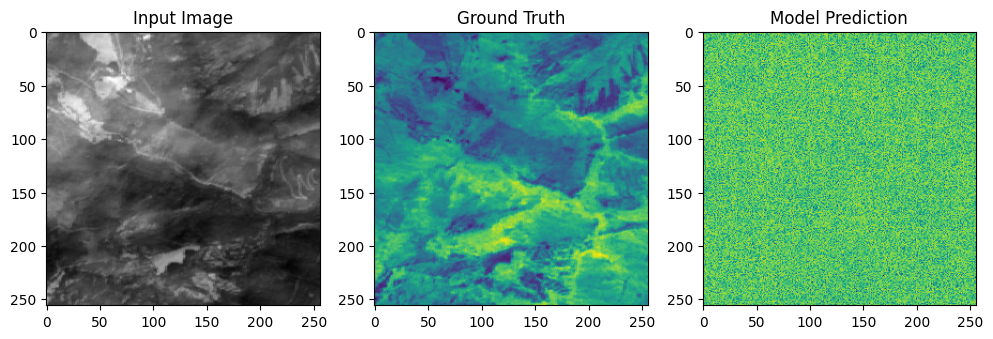

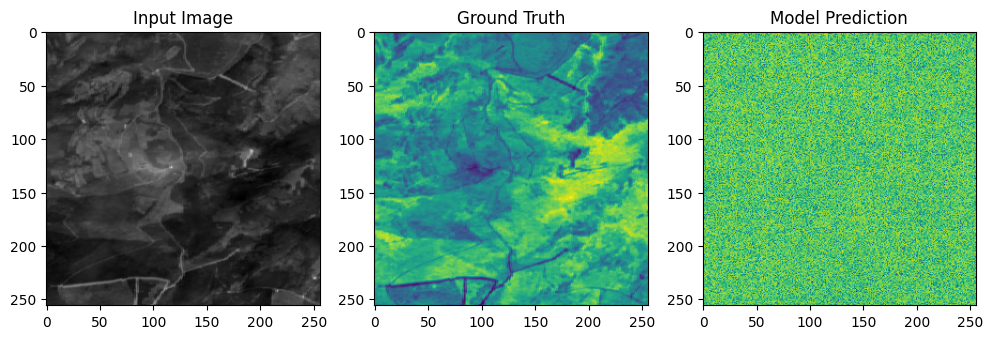

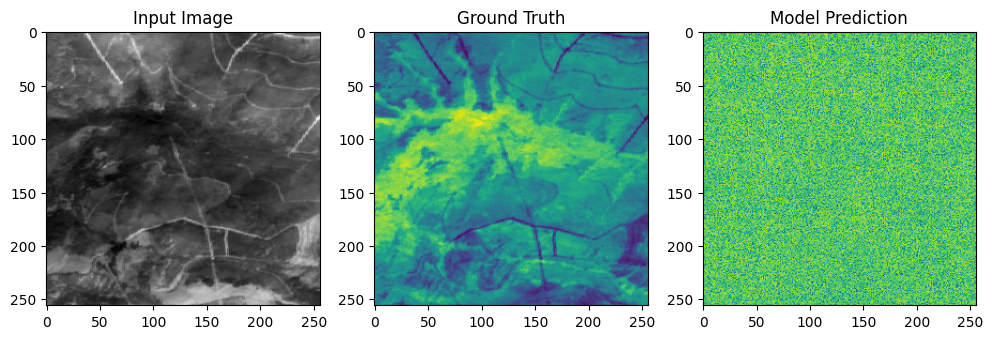

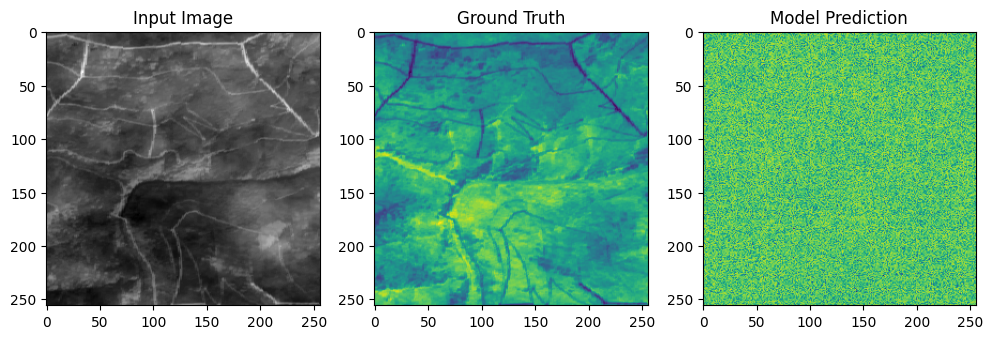

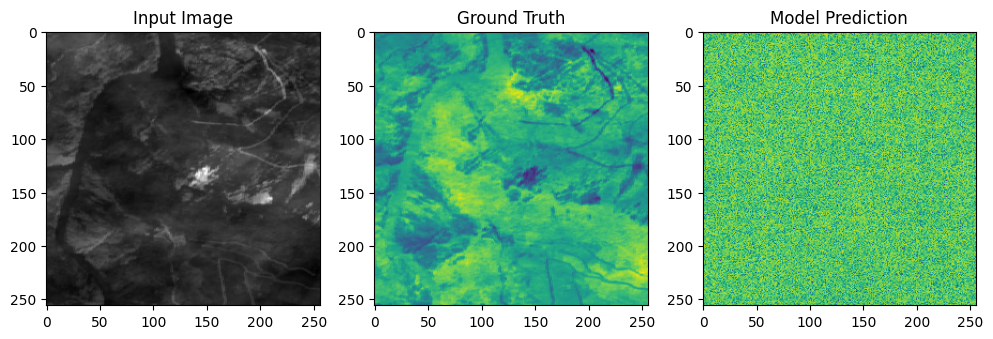

In [ ]:
# Load the results from the pickle file
with open(save_path, 'rb') as f:
    results = pickle.load(f)

# Example: visualize predictions for the first fold
first_fold_results = results[5]
visualize_predictions(
    first_fold_results['inputs'],
    first_fold_results['targets'],
    first_fold_results['outputs'],
    num_samples=5
)